In [1]:
!pip3 install mesa

In [2]:
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model 


from mesa.space import SingleGrid, MultiGrid
# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random

from queue import Queue


#Definición del grid


In [3]:
def get_grid(model):


    #NOTA IMPORTANTE DEL GRID. como ahora no estamos haciendo posiciones al azar, todo empezara en posiciones predeterminadas, por lo que podemos poner cada semaforo individualmente, asi como puntos pivote donde
    # SI el carro va a girar, y llega a cierto X,Y = haga el giro.

    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        for content in cell_content:
          if isinstance(content, Carro):
            grid[x][y] = 4
          else:
            grid[x][y] = content.live
        
    return grid

In [4]:
time_end = time.time() + 20


class Semaforo(Agent):

    def __init__(self, unique_id, pos, model, isFirst, otherX, otherY):

        super().__init__(unique_id, model)

        global time_end
        global CONT
        self.otherX = otherX
        self.otherY = otherY
        
        #otherX y OtherY es la posicion del semaforo al que va a estar viendo. todos en un carril pueden ver
        #a solo uno de otro carril porque seguiran el mismo patron por carril.

        #El semaforo va a tener 3 estados en su live. Estado 1 es rojo, estado 2 es amarillo, estado 3 es verde. 
        #El estado amarillo no afecta a otros semaforos, pero si a los carros, cuando es amarillo, estos paran su movimiento.
        #Cuando el semaforo esta en rojo, va a ser detectado por los semaforos de los carriles que cruzen a los actuales y estos cambiaran a verde.
        #El semaforo estara verde por una cierta cantidad de tiempo, igual para el estado amarillo. 
        #El rojo cambiara solo cuando un semaforo observado este en verde, por lo que permanecera en rojo el tiempo que
        # el otro semaforo este en verde + amarillo.

        #nosotros declaramos que linea empieza verde primero en el modelo.


        #si es primero
        if isFirst == True:
            #verde
            self.live = 3
            #self.next_state = 3
        else:
            #si no, rojo
            self.live = 1
            #self.next_state = 1
        
        
        #su siguiente estado es si mismo
        #self.next_state = self.live
        #self.this_cell = self.model.grid.get_cell_list_contents([(self.otherX,self.otherY)])

    def step(self):
        x, y = self.pos
        this_cell = self.model.grid.get_cell_list_contents([(self.otherX,self.otherY)])
        for content in this_cell:

          #si el content es otro semaforo
          if isinstance(content, Semaforo):
            #print(content.live)
            #(este rojo y el otro rojo, cambia a verde.)
            if (self.live == 1 and content.live == 1):
                self.live = 3
                #self.next_state = 3

                # si es verde, hacer esto:
            elif self.live == 3:
                
                #si es verde, y el tiempo es mayor a time_end, cambia a amarillo y agrega el tiempo de espera a amarillo.
                if CONT == 4:
                  self.live = 2
                  #self.next_state = 2

                #si es amarillo, hacer esto:
            elif self.live == 2:
                #cambiamos de amarillo a rojo, como el tiempo end es global, lo cambiamos a el timer del verde.
                if CONT == 7:
                  self.live = 1
                  #self.next_state = 1

            

    #def advance(self):
        #self.live = self.next_state

In [5]:
#agente carro
class Carro(Agent):

    def __init__(self, unique_id, pos, model, direccion, posDestino):

        super().__init__(unique_id, model)

        #si es primero
        self.live = 4
        #self.x,self.y = pos
        self.xD, self.yD = posDestino
        self.canMove = True
        self.willTurn = random.randint(0, 1)
        self.revisa = True
        self.revisaNext = True
        self.HV = 0
        self.direccion = direccion
        global width
        global height

        print(self.xD, self.yD)

        if self.direccion == -1 or self.direccion == 1:
          #HV = 1 = horizontal, HV = 0 = vertical
          self.HV = 1
          print("hori")
        else:
          self.HV = 0
          print("verti")

    def step(self):
        self.x,self.y = self.pos
        self.canMove = True
        #la direccion hay que darla por ints

        #   1  =  izquierda
        #    -1  =  derecha
        #    -2  =  abajo
        #   2  =  arriba
        

        this_cell = self.model.grid.get_cell_list_contents([(self.x,self.y)])
        for content in this_cell:
          if isinstance(content,Semaforo):
                  if content.live == 1 or content.live == 2:
                    self.canMove = False
                  else:
                    self.canMove = True
                    self.revisaNext = False
        
        #MOVIMIENTO EN LAS LINEAS hori
        if self.HV == 1 and self.canMove == True:
          #self y - 2


          if self.direccion == 1:
            if self.revisa == True and self.y-2 > 0:
              this_cell = self.model.grid.get_cell_list_contents([(self.x,self.y-1)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True
              this_cell = self.model.grid.get_cell_list_contents([(self.x,self.y-2)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True

          elif self.direccion == -1:
            if self.revisa == True and self.y+2 < width-1:
              this_cell = self.model.grid.get_cell_list_contents([(self.x,self.y+1)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True
              this_cell = self.model.grid.get_cell_list_contents([(self.x,self.y+2)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True

                    
          if self.canMove == True:
            if self.y < self.yD:
              self.model.grid.move_agent(self,(self.x,self.y+1))
            elif self.y > self.yD:
              self.model.grid.move_agent(self,(self.x,self.y-1))
            elif self.x < self.xD:
              self.model.grid.move_agent(self,(self.x+1,self.y))
            elif self.x > self.xD:
              self.model.grid.move_agent(self,(self.x-1,self.y))

              #nada   


        #MOVIMIENTO EN LAS LINEAS verti
        elif self.HV == 0 and self.canMove == True:


          if self.direccion == 2:
            if self.revisa == True and self.x-2 > 0:
              this_cell = self.model.grid.get_cell_list_contents([(self.x-1,self.y)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True
              this_cell = self.model.grid.get_cell_list_contents([(self.x-2,self.y)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True

          elif self.direccion == -2:
            if self.revisa == True and self.x+2 < height-1:
              this_cell = self.model.grid.get_cell_list_contents([(self.x+1,self.y)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True
              this_cell = self.model.grid.get_cell_list_contents([(self.x+2,self.y)])
              for content in this_cell:
                  if isinstance(content,Carro):
                    self.canMove = False
                  else:
                    self.canMove = True

                    

          if self.canMove == True:
            if self.x < self.xD:
              self.model.grid.move_agent(self,(self.x+1,self.y))
            elif self.x > self.xD:
              self.model.grid.move_agent(self,(self.x-1,self.y))
            elif self.y < self.yD:
              self.model.grid.move_agent(self,(self.x,self.y+1))
            elif self.y > self.yD:
              self.model.grid.move_agent(self,(self.x,self.y-1))

              #nada     


    def advance(self):
        #self.live = self.next_state
        self.revisa = self.revisaNext

##Modelo

In [6]:



class RobotBoxes(Model):
    def __init__(self, width, height):
        self.semaforos=4
        self.grid = MultiGrid(width, height, True)
        self.schedule = SimultaneousActivation(self)
        self.carros=0


        # Sapwn Carros
        #carro1 = Carro(1, (int(width/2)-1,0), self, 2, (4,9))
        #self.grid.place_agent(carro1, (int(width/2)-1,0))
        #_(self, unique_id, pos, model, direccion, posDestino):
        


        #   -1  =  izquierda
        #    1  =  derecha
        #    2  =  abajo
        #   -2  =  arriba
        



 #       carro2 = Carro(2, (int(width-1),int(height/2)), self, -2, (int(height/2-1),0))
 #       self.grid.place_agent(carro2, (int(width-1),int(height/2)))
 #       self.schedule.add(carro2)

 #       carro3 = Carro(3, (int(width/2-1),int(height-1)), self, -1, (int(height/2-1),0))
 #       self.grid.place_agent(carro3, (int(width/2-1),int(height-1)))
 #       self.schedule.add(carro3)

 #       carro4 = Carro(4, (0,int(height/2)-1), self, 2, (int(height/2-1),0))
 #       self.grid.place_agent(carro4, (0,int(height/2)-1))
 #       self.schedule.add(carro4)

 #       carro6 = Carro(26, (int(width-1),int(height/2)), self, -2, (0,int(height/2)))
 #       self.grid.place_agent(carro6, (int(width-1),int(height/2)))
 #       self.schedule.add(carro6)

 #       carro5 = Carro(33, (int(height/2),0), self, 1, (0,int(height/2)))
 #       self.grid.place_agent(carro5, (int(height/2),0))
 #       self.schedule.add(carro5)

        #Spawn Semaforos
        #def __init__(self, unique_id, pos, model, isFirst, otherX, otherY):

        #Los semaforo FALSE observan a algun semaforo TRUE, los TRUE observan a algun semaforo en FALSE. Cuando un semaforo verde (TRUE) pasa a ser rojo (FALSE) despues de x tiempo, los semaforos FALSE, que estaban viendo al
        # semaforo TRUE, ven que este pasa a FALSE, y hacen su cambio a TRUE



        semaforo1 = Semaforo(1, (int(width/2)-2,int(height/2)-1), self, False, int(width/2),int(height/2-2))
        self.grid.place_agent(semaforo1, (int(width/2)-2,int(height/2)-1))
        self.schedule.add(semaforo1)

        semaforo2 = Semaforo(2, (int(width/2),int(height/2-2)), self, True, int(width/2)-2,int(height/2)-1)
        self.grid.place_agent(semaforo2, (int(width/2),int(height/2-2)))
        self.schedule.add(semaforo2)

        semaforo3 = Semaforo(3, (int(width/2+1),int(height/2)), self, False, int(width/2-1),int(height/2+1))
        self.grid.place_agent(semaforo3, (int(width/2+1),int(height/2)))
        self.schedule.add(semaforo3)

        semaforo4 = Semaforo(4, (int(width/2-1),int(height/2+1)), self, True, int(width/2)-2,int(height/2)-1)
        self.grid.place_agent(semaforo4, (int(width/2-1),int(height/2+1)))
        self.schedule.add(semaforo4)


        '''
        Aquí pondremos el algoritmo para el programa de luces, falta implementarlo
        con el queue para obtener un orden de los semaforos
        '''
        # Aquí definimos con colector para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": get_grid})
        
    def step(self):
        global contid
        global totalCarros


        prob = random.randrange(1,4)

        if prob == 1 and self.carros<totalCarros:
          self.carros += 1
          contid = contid+1
          mylist = [(int(height/2),0), (height-1,int(width/2)), (int(height/2-1),int(width-1)), (0,int(width/2)-1)]
          
          (x, y) = random.choice(mylist)
          
          if x == int(height/2):
            mylistC = [(0,int(width/2)), (int(height/2),width-1), (height-1,int(width/2)-1)]
            xd, yd = random.choice(mylistC)
            print(xd, yd)
            carro = Carro(contid, (x,y), self, -1, (xd,yd))
            self.grid.place_agent(carro, (x,y))
            self.schedule.add(carro)
            print("if 1")
          elif x == int(height-1):
            mylistC = [(0,int(width/2)), (int(height/2-1),0), (int(height/2),width-1)]
            xd, yd = random.choice(mylistC)
            print(xd, yd)
            carro = Carro(contid, (x,y), self, 2, (xd,yd))
            self.grid.place_agent(carro, (x,y))
            self.schedule.add(carro)
            print("if 2")
          elif x == int(height/2-1):
            mylistC = [(0,int(width/2)), (int(height/2-1),0), (height-1,int(width/2-1))]
            xd, yd = random.choice(mylistC)
            print(xd, yd)
            carro = Carro(contid, (x,y), self, 1, (xd,yd))
            self.grid.place_agent(carro, (x,y))
            self.schedule.add(carro)
            print("if 3")
            #elif x == 0:
          else:
            mylistC = [(int(height/2)-1,0), (height-1,int(width/2-1)), (int(height/2),width-1)]
            xd, yd = random.choice(mylistC)
            print(xd, yd)
            carro = Carro(contid, (x,y), self, -2, (xd,yd))
            self.grid.place_agent(carro, (x,y))
            self.schedule.add(carro)
            print("if 4")

        
        self.datacollector.collect(self)
        self.schedule.step()
        

In [7]:
#Datos Iniciales
tiempoEjecucion = 1.0
iniRobots = 5
#iniBoxes = int(input("Ingresa numero de cajas: "))
width = 20 #Ancho predeterminado
height = 20 #alto predeterminado
NUM_GENERATIONS = 50
#GRID_SIZE = 20
segundos = 3
TURNO = 1 #ESTE IRÁ DE 1 A 4, DETERMINA A QUÉ SEMAFORO LE TOCA EL VERDE
CONT = 0 #RANGO DE 0 A 7 (8 FRAMES), LOS PRIMEROS 5 FRAMES SON DE LUZ VERDE LOS OTROS 3 DE LUZ AMARILLA (contadr cilo de luz verde y amarilla)
contid = 5
totalCarros = 10

start_time = time.time()
time_end = time.time() + segundos
#model = RobotBoxes(width, height, iniBoxes, iniRobots)
model = RobotBoxes(width, height)
for i in range(NUM_GENERATIONS):
    if (CONT< 8): #Sigue en el turno del semaforo N
        model.step()
        CONT+=1
    else:
        model.step()
        CONT = 0
        

#while time.time() < time_end:
 # model.step()


#print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
#print('Numero total de movimiento: ', TOTAL_MOVES)
#if(NUM_GENERATIONS > 250):
#  print("No se apilaron todas las cajas")
#else:
#  print("Se apilaron todas las cajas")

9 0
9 0
verti
if 2
9 0
9 0
hori
if 3
0 10
0 10
hori
if 1
9 0
9 0
hori
if 3
10 19
10 19
verti
if 2
9 0
9 0
hori
if 3
9 0
9 0
hori
if 3
9 0
9 0
verti
if 4
9 0
9 0
verti
if 4
19 9
19 9
hori
if 3


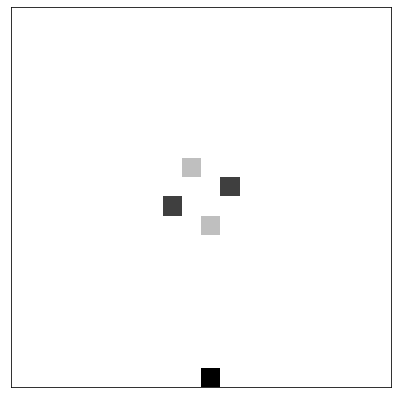

In [8]:
all_grid = model.datacollector.get_model_vars_dataframe()
#print(type(all_grid))
#print(all_grid)



fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

anim